# Digging further: Percentage double-scored

In this notebook we look how PRMSE depends on % double-scored responses. 
We pick 100 rater pairs, sample different % of double-scored responses and compute PRMSE. 

In [55]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import itertools
import numpy as np

import json

from rsmtool.utils.prmse import prmse_true
from rsmtool.analyzer import Analyzer

from matplotlib import pyplot as plt

from pathlib import Path

%matplotlib inline

In [31]:
# let's define some settings and read the data
config = json.load(open('settings.json'))
fig_dir = Path('../paper_overleaf/figures')
df = pd.read_csv('../data/data.csv')
df_raters = pd.read_csv('../data/raters.csv')
metrics_dict = json.load(open('metrics_dict.json')) # the dictionary with metrics name we'll use for plots
df['system'] = df[config['sample_system']] # we use one sample system as defined in the config

In [32]:
human_columns = df_raters['rater_id'].values

In [33]:
# generate pairs of raters for each group

def generate_rater_pairs_for_group(df_group, n_pairs):
    raters = df_group['rater_id']
    # get all possible rater pairs
    rater_pairs = ['{}+{}'.format(p[0], p[1]) for p in itertools.combinations(raters, 2)]
    np.random.seed(100)
    selected_pairs = np.random.choice(rater_pairs, n_pairs, replace=False)
    return selected_pairs

In [34]:
# randomly sample 50 pairs for each group
selected_pairs = df_raters.groupby('category').apply(generate_rater_pairs_for_group, n_pairs=50)
pair_dict = selected_pairs.to_dict()

In [35]:
# we make one long DF to speed up computation
data = []
for c in df_raters['category'].unique():
    pairs = pair_dict[c]
    for p in pairs:
        (h1, h2) = p.split('+')
        df_p = pd.DataFrame({'pair': p,
                              'h1': df[h1],
                              'h2': df[h2],
                              'system': df['system'], 
                              'true': df['true'],
                              'category': c})
        data.append(df_p)
    df_long = pd.concat(data)

In [36]:
# let's now create a DF with different percentage double-scored
perc_double_scored = [1, 10, 25, 50, 75, 90, 100]
# we now create a df with this values
np.random.seed(123)
df_list = []
for p in perc_double_scored:
    print(p)
    to_sample = int(p/100*len(df_long))
    mask  = np.zeros(len(df_long), dtype=int)
    mask[: to_sample]=1
    np.random.shuffle(mask)
    mask = mask.astype(bool)
    df_double = df_long[mask].copy()
    df_single = df_long[~mask].copy()
    df_double['percentage'] = p
    df_single['percentage'] = p
    df_single['h2'] = None
    df_list.extend([df_double, df_single])
df_perc = pd.concat(df_list)
df_perc['h1'] = pd.to_numeric(df_perc['h1'], errors='coerce')
df_perc['h2'] = pd.to_numeric(df_perc['h2'], errors='coerce')

1
10
25
50
75
90
100


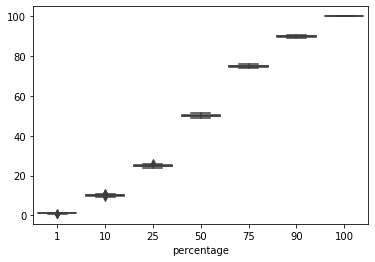

In [8]:
# A sanity check plot
sns.boxplot(data=df_perc.groupby(['pair', 'percentage']).apply(lambda x: len(x[~x['h2'].isnull()])/len(x)*100).unstack())

In [9]:
# now let's compute prmse. This can take a lot of time since we are computing over a large amount of data:
# 200 pairs, 7 percentage points. 
df_prmse  = df_perc.groupby(['pair', 'percentage']).apply(lambda x: prmse_true(x['system'],
                                                                               x[['h1', 'h2']])).reset_index()

In [10]:
df_prmse.columns = ['pair', 'percentage', 'prmse']

In [18]:
# add rater category
df_prmse['h1'] = df_prmse['pair'].apply(lambda x: x.split("+")[0])
df_prmse_with_category = pd.merge(df_prmse, df_raters, left_on='h1', right_on='rater_id')

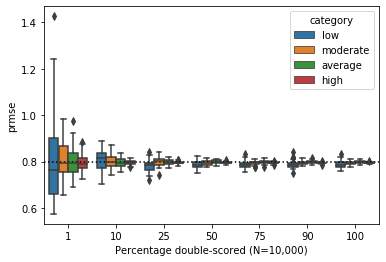

In [46]:
ax = sns.boxplot(x='percentage', y='prmse', hue='category',
                 hue_order=config['rater_categories'],
                 data=df_prmse_with_category)
ax.set_xlabel("Percentage double-scored (N=10,000)")
ax.axhline(r2_score(df['true'], df['system']), color='black', ls=':')
plt.savefig(fig_dir / 'percentage.png')

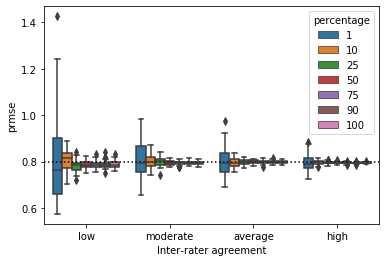

In [74]:
ax = sns.boxplot(x='category', y='prmse', hue='percentage',
                 order=config['rater_categories'],
                 data=df_prmse_with_category)
ax.set_xlabel("Inter-rater agreement")
ax.axhline(r2_score(df['true'], df['system']), color='black', ls=':')
plt.savefig(fig_dir / 'percentage.png')

In [39]:
df_prmse_with_category.groupby(['category', 'percentage'])['prmse'].describe()

count      mean       std       min       25%       50%  \
category percentage                                                            
average  1            50.0  0.797375  0.065570  0.690098  0.753711  0.793128   
         10           50.0  0.795000  0.020693  0.756465  0.781277  0.792426   
         25           50.0  0.797651  0.011925  0.772694  0.788087  0.797625   
         50           50.0  0.798757  0.008560  0.779158  0.792135  0.799443   
         75           50.0  0.797986  0.007814  0.777172  0.793984  0.796910   
         90           50.0  0.798372  0.006647  0.783989  0.794802  0.798290   
         100          50.0  0.797993  0.006176  0.786276  0.794200  0.798012   
high     1            50.0  0.795679  0.035503  0.724373  0.772605  0.790350   
         10           50.0  0.796779  0.009310  0.776347  0.791615  0.797982   
         25           50.0  0.794816  0.006275  0.783175  0.791974  0.794602   
         50           50.0  0.794985  0.003731  0.787442  0.792796  0.795281   
         75           50.0  0.794390  0.003575  0.785089  0.792217  0.793973   
         90           50.0  0.794528  0.003135  0.786662  0.792841  0.794548   
         100          50.0  0.794571  0.002894  0.789072  0.792730  0.794620   
low      1            50.0  0.802066  0.180873  0.574960  0.660486  0.763634   
         10           50.0  0.804352  0.050333  0.703783  0.773910  0.816368   
         25           50.0  0.780646  0.023116  0.720156  0.765490  0.783311   
         50           50.0  0.786856  0.018061  0.750427  0.777232  0.785462   
         75           50.0  0.788433  0.016409  0.753408  0.777666  0.787075   
         90           50.0  0.787529  0.015406  0.750708  0.777478  0.785500   
         100          50.0  0.788335  0.013956  0.758263  0.778119  0.785620   
moderate 1            50.0  0.807175  0.079861  0.656875  0.755464  0.793017   
         10           50.0  0.802244  0.031222  0.743850  0.780228  0.796665   
         25           50.0  0.799728  0.016891  0.742764  0.787278  0.801764   
         50           50.0  0.795803  0.010853  0.774778  0.787379  0.796097   
         75           50.0  0.795002  0.008847  0.774774  0.790065  0.796589   
         90           50.0  0.795211  0.008039  0.780488  0.789124  0.793609   
         100          50.0  0.795663  0.008237  0.778666  0.789868  0.795231   

                          75%       max  
category percentage                      
average  1           0.838146  0.976487  
         10          0.809210  0.838948  
         25          0.806025  0.819420  
         50          0.805943  0.811096  
         75          0.802995  0.814352  
         90          0.802298  0.813672  
         100         0.801590  0.812113  
high     1           0.814887  0.882525  
         10          0.801724  0.813633  
         25          0.797911  0.807650  
         50          0.797228  0.805299  
         75          0.796403  0.803621  
         90          0.795959  0.802451  
         100         0.796432  0.802677  
low      1           0.901708  1.425568  
         10          0.835257  0.887065  
         25          0.794327  0.839760  
         50          0.796407  0.824893  
         75          0.795640  0.834641  
         90          0.791915  0.841591  
         100         0.796257  0.832655  
moderate 1           0.867577  0.981308  
         10          0.818217  0.872257  
         25          0.812580  0.841337  
         50          0.804753  0.816751  
         75          0.799116  0.812113  
         90          0.800079  0.814932  
         100         0.799917  0.812767

In [57]:
#let's also look at other metrics

df_metrics = df_perc.groupby(['pair', 'percentage']).apply(lambda x: Analyzer.metrics_helper(x['h_mean'], x['system']))

In [60]:
df_metrics.reset_index(inplace=True)

In [63]:
df_metrics_long = df_metrics.melt(id_vars = ['pair', 'percentage'],
                                 value_vars = ['wtkappa', 'corr', 'R2'],
                                 var_name = 'metrics', 
                                 value_name = 'value')
df_metrics_long['h1'] = df_metrics_long['pair'].apply(lambda x: x.split("+")[0])
df_metrics_with_category = pd.merge(df_metrics_long, df_raters, left_on='h1', right_on='rater_id')

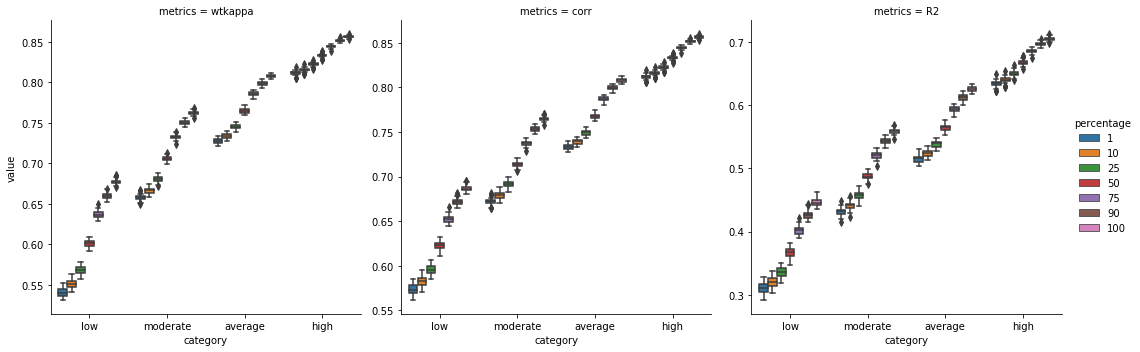

In [75]:
ax = sns.catplot(x='category', y='value', col='metrics',
                 hue='percentage', order=config['rater_categories'],
                 data=df_metrics_with_category, kind='box',
                sharey=False)
plt.savefig(fig_dir / 'percentage_other.png')